<a href="https://colab.research.google.com/github/jagadeep31/Learn-Flow-Task-2-Restaurant-Revenue-Prediction-/blob/main/Restaurant_Revenue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

In [19]:
dataset = pd.read_csv('train.csv')
print("Dataset_shape:",dataset.shape)
test_df = pd.read_csv('test.csv')
print("Testdataset_shape:",test_df.shape)

Dataset_shape: (137, 43)
Testdataset_shape: (100000, 42)


In [20]:
def display_all(dataset):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(dataset)
display_all(dataset.head().transpose())

,0,1,2,3,4
Id,0,1,2,3,4
Open Date,07/17/1999,02/14/2008,03/09/2013,02/02/2012,05/09/2009
City,İstanbul,Ankara,Diyarbakır,Tokat,Gaziantep
City Group,Big Cities,Big Cities,Other,Other,Other
Type,IL,FC,IL,IL,IL
P1,4,4,2,6,3
P2,5.0,5.0,4.0,4.5,4.0
P3,4.0,4.0,2.0,6.0,3.0
P4,4.0,4.0,5.0,6.0,4.0
P5,2,1,2,4,2


In [21]:
dataset.isnull().sum().sort_index()/len(dataset)

City          0.0
City Group    0.0
Id            0.0
Open Date     0.0
P1            0.0
P10           0.0
P11           0.0
P12           0.0
P13           0.0
P14           0.0
P15           0.0
P16           0.0
P17           0.0
P18           0.0
P19           0.0
P2            0.0
P20           0.0
P21           0.0
P22           0.0
P23           0.0
P24           0.0
P25           0.0
P26           0.0
P27           0.0
P28           0.0
P29           0.0
P3            0.0
P30           0.0
P31           0.0
P32           0.0
P33           0.0
P34           0.0
P35           0.0
P36           0.0
P37           0.0
P4            0.0
P5            0.0
P6            0.0
P7            0.0
P8            0.0
P9            0.0
Type          0.0
revenue       0.0
dtype: float64

In [22]:
print(dataset['City'].nunique(), test_df['City'].nunique())
test_df.loc[test_df['Type']=='MB', 'Type'] = 'DT'
dataset.drop('City', axis=1, inplace=True)
test_df.drop('City', axis=1, inplace=True)
import datetime
dataset.drop('Id',axis=1,inplace=True)
dataset['Open Date']  = pd.to_datetime(dataset['Open Date'])
test_df['Open Date']  = pd.to_datetime(test_df['Open Date'])
launch_date = datetime.datetime(2015, 3, 23)

34 57


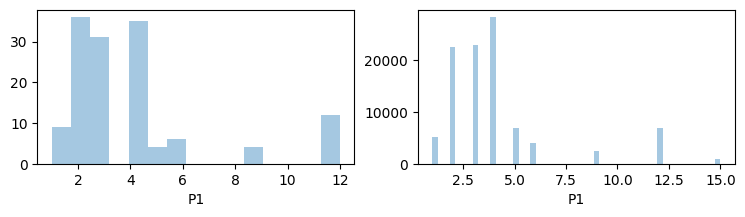

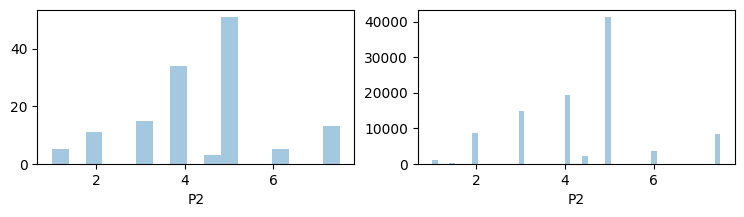

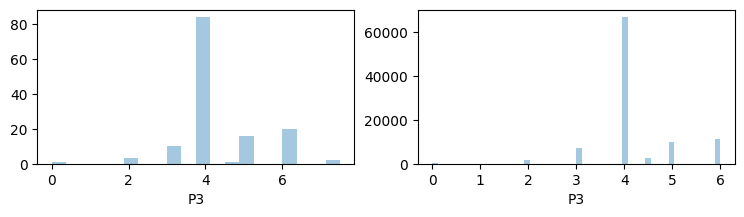

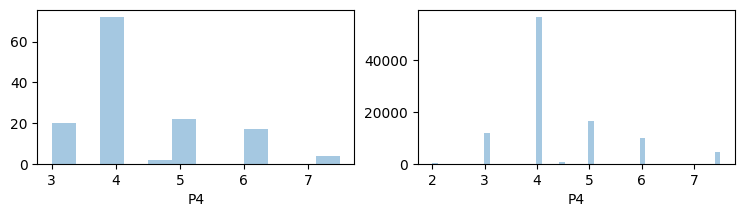

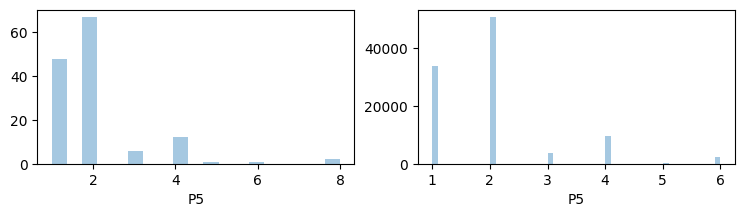

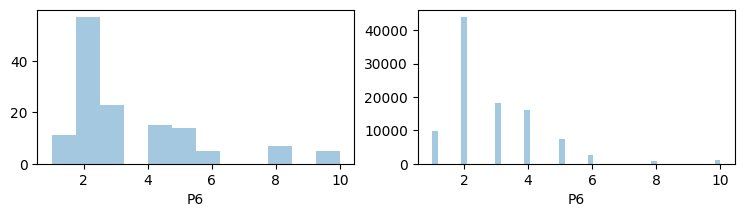

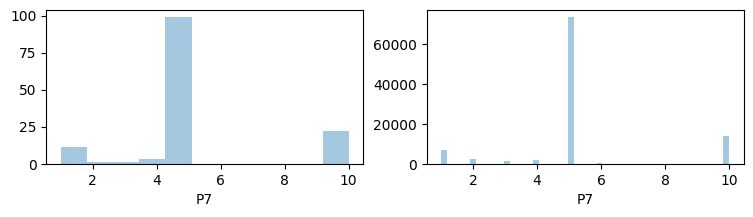

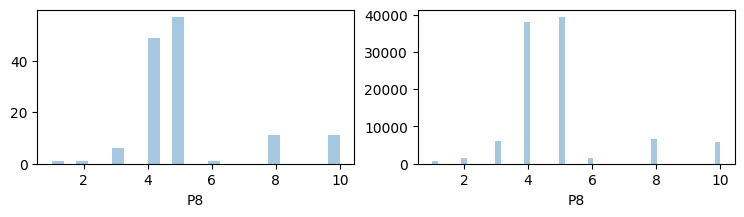

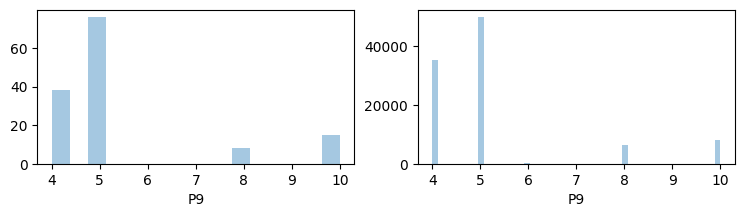

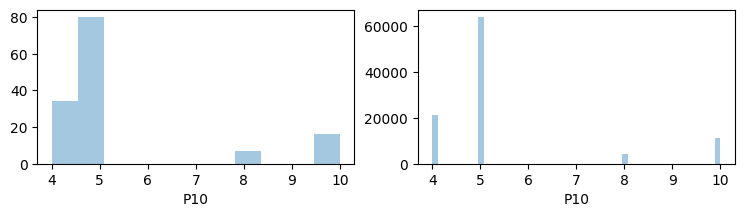

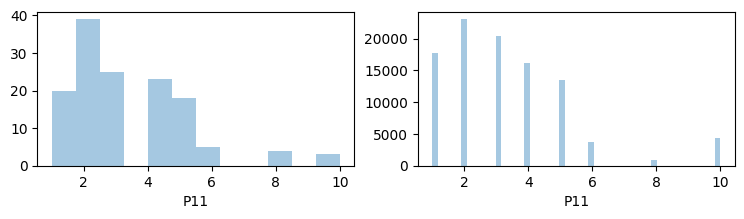

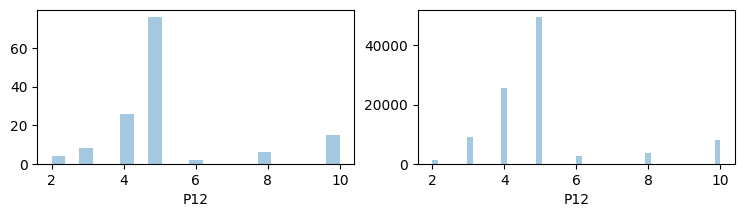

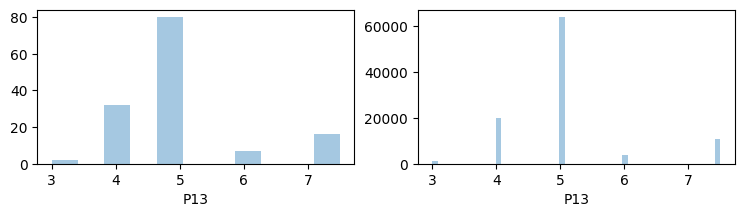

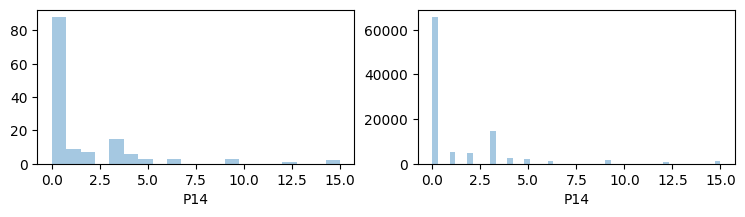

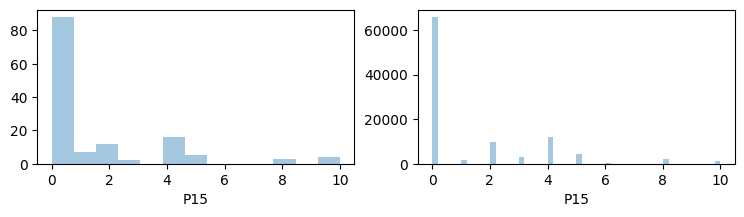

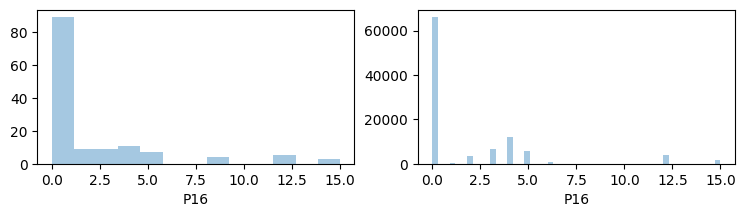

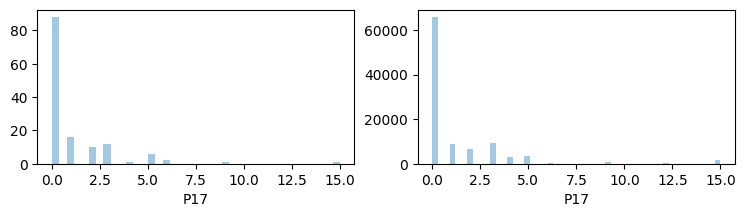

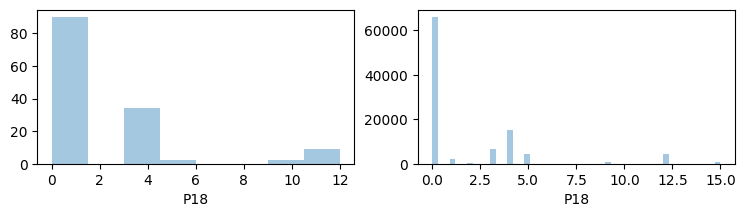

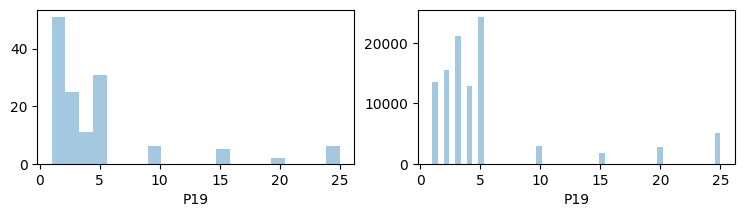

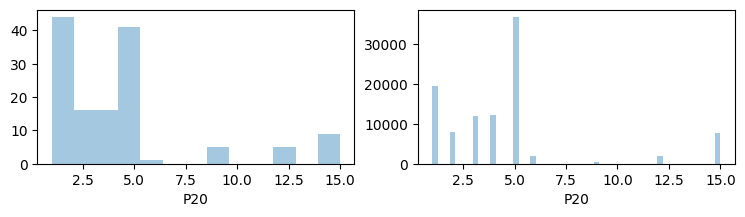

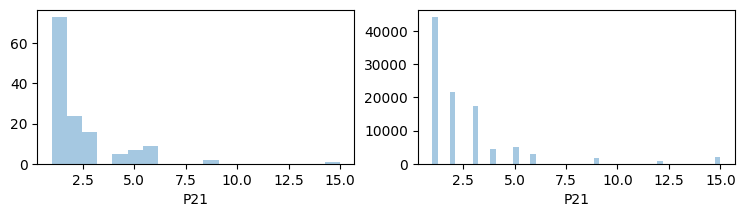

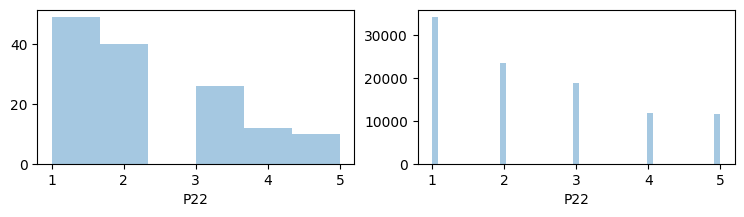

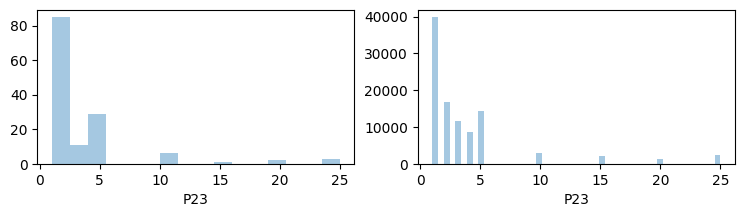

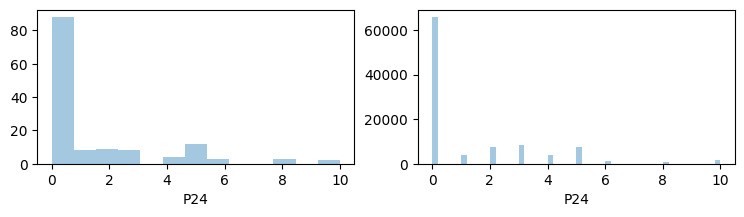

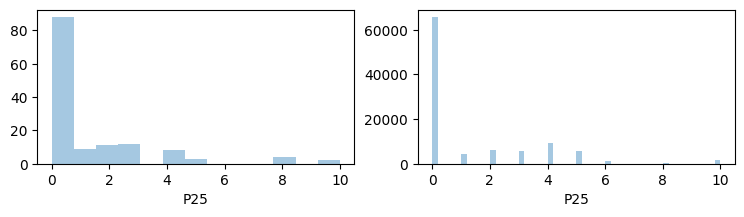

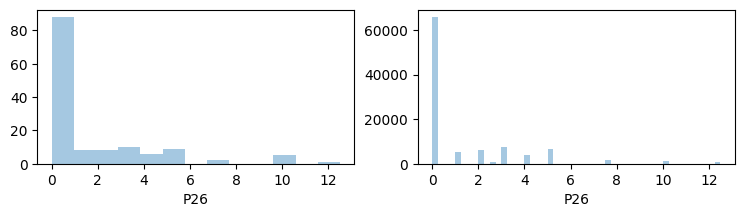

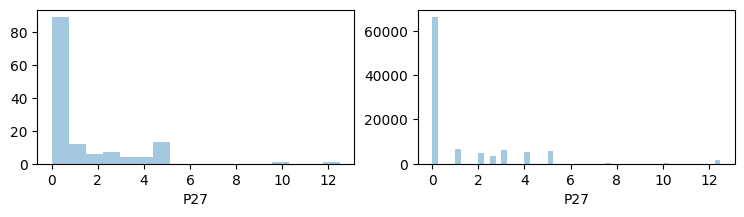

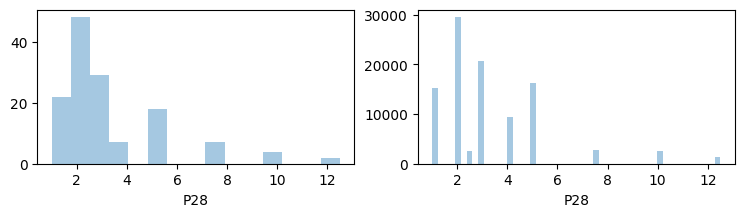

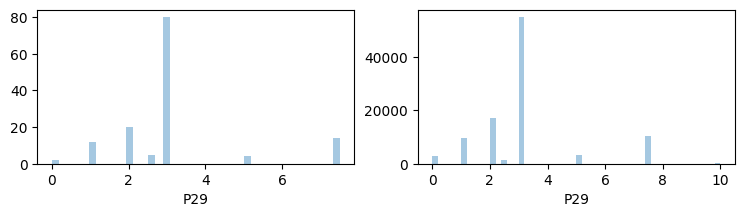

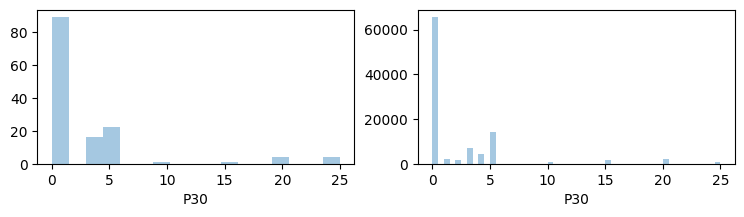

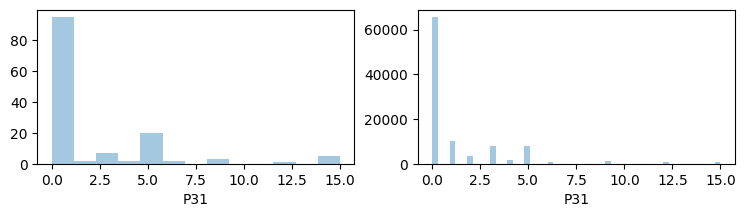

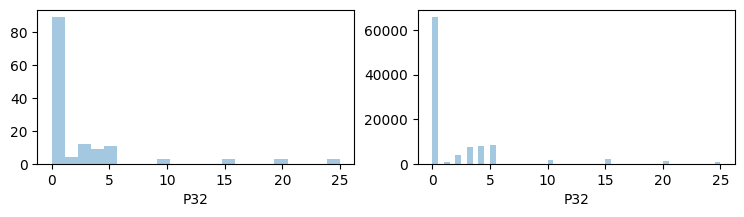

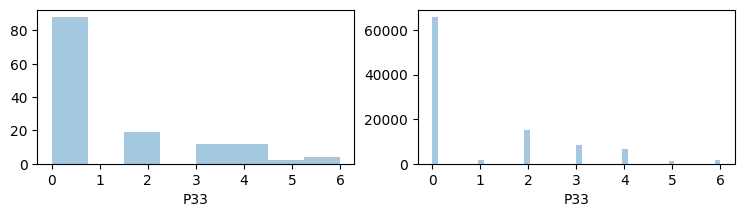

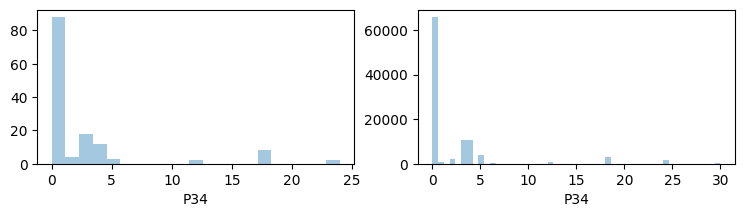

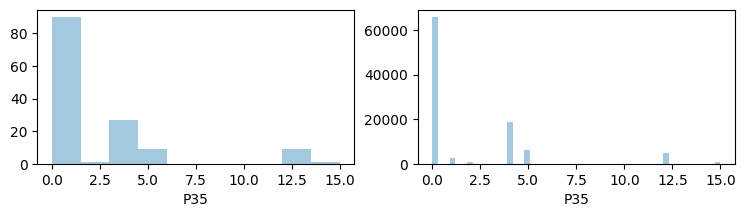

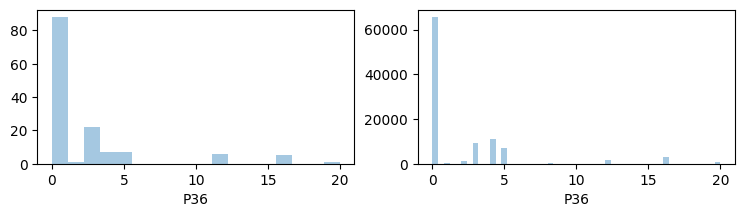

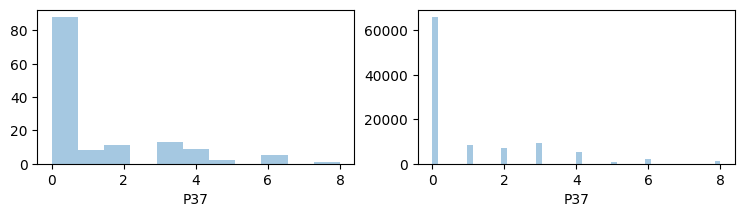

In [23]:
# scale days open
dataset['Days Open'] = (launch_date - dataset['Open Date']).dt.days / 1000
test_df['Days Open'] = (launch_date - test_df['Open Date']).dt.days / 1000
dataset.drop('Open Date', axis=1, inplace=True)
test_df.drop('Open Date', axis=1, inplace=True)
plt.rc('figure', max_open_warning = 0)
for i in range(1,38):
    fig, ax = plt.subplots(1,2, figsize=(9, 2))
    g1 = sns.distplot(dataset['P{}'.format(i)], ax=ax[0], kde=False);
    g2 = sns.distplot(test_df['P{}'.format(i)], ax=ax[1], kde=False);
    fig.show()

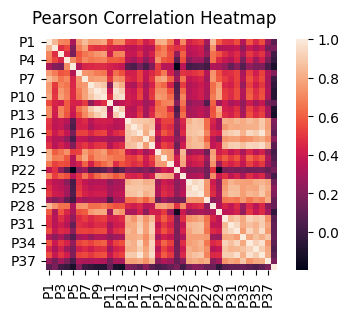

In [24]:
# Correlation between numeric features with revenue
plt.figure(figsize=(5, 3))
sns.heatmap(dataset.drop(['revenue','City Group','Type'], axis=1).corr(), square=True)
plt.suptitle('Pearson Correlation Heatmap')
plt.show();

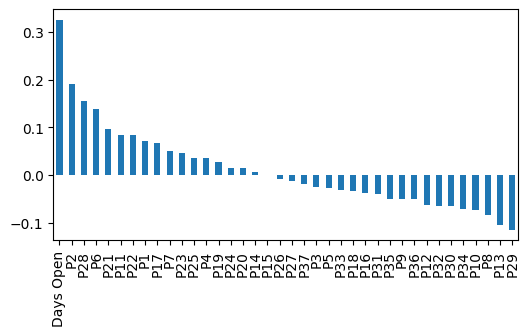

In [25]:
corr_with_revenue = dataset.drop(['City Group','Type'],axis=1).corr()['revenue'].sort_values(ascending=False)
plt.figure(figsize=(6,3))
corr_with_revenue.drop('revenue').plot.bar()
plt.show();

In [26]:
#Multiple imputation for P1-P37
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_train = IterativeImputer(max_iter=30, missing_values=0, sample_posterior=True, min_value=1, random_state=37)
imp_test = IterativeImputer(max_iter=30, missing_values=0, sample_posterior=True, min_value=1, random_state=23)
p_data = ['P'+str(i) for i in range(1,38)]
dataset[p_data] = np.round(imp_train.fit_transform(dataset[p_data]))
test_df[p_data] = np.round(imp_test.fit_transform(test_df[p_data]))

# drop_first=True for Dummy Encoding for object types, and drop_first=False for OHE
columnsToEncode = dataset.select_dtypes(include=[object]).columns
df = pd.get_dummies(dataset, columns=columnsToEncode, drop_first=False)
test_df = pd.get_dummies(test_df, columns=columnsToEncode, drop_first=False)
df['revenue'] = np.log1p(df['revenue'])
X, y = df.drop('revenue', axis=1), df['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=118)

In [27]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
params_knn = {'n_neighbors' : [3, 5, 7, 9, 11],}
knn_model = KNeighborsRegressor()
knn_regressor = GridSearchCV(knn_model, params_knn, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
knn_regressor.fit(X_train, y_train)
print(f'Optimal neighbors: {knn_regressor.best_params_["n_neighbors"]}')
print(f'Best score: {knn_regressor.best_score_}')

Optimal neighbors: 11
Best score: -0.43011660772832583


In [28]:
knn_model = KNeighborsRegressor(n_neighbors=knn_regressor.best_params_["n_neighbors"])
knn_model.fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train)
y_pred = knn_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -7.188173431615837
Test r2 score:  0.1434305705894996
Train RMSE: 0.4071
Test RMSE: 0.5115


In [29]:
params_xgb = {
    'learning_rate': [.1, .5, .7, .9, .95, .99, 1],
    'colsample_bytree': [.3, .4, .5, .6],
    'max_depth': [4],
    'alpha': [3],
    'subsample': [.5],
    'n_estimators': [30, 70, 100, 200]
}

xgb_model = XGBRegressor()
xgb_regressor = GridSearchCV(xgb_model, params_xgb, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
xgb_regressor.fit(X_train, y_train)
print(f'Optimal lr: {xgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal colsample_bytree: {xgb_regressor.best_params_["colsample_bytree"]}')
print(f'Optimal n_estimators: {xgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {xgb_regressor.best_score_}')

Optimal lr: 0.5
Optimal colsample_bytree: 0.3
Optimal n_estimators: 100
Best score: -0.40207273265664034


In [30]:
xgb_model = XGBRegressor(learning_rate=xgb_regressor.best_params_["learning_rate"],
                         colsample_bytree=xgb_regressor.best_params_["colsample_bytree"],
                         max_depth=4, alpha=3, subsample=.5,
                         n_estimators=xgb_regressor.best_params_["n_estimators"], n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.13518033251975803
Test r2 score:  0.04491810669499474
Train RMSE: 0.2624
Test RMSE: 0.5401


In [31]:
# XGB with early stopping
xgb_model.fit(X_train, y_train, early_stopping_rounds=4,
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -26.25981873824912
Test r2 score:  0.08884682460951354
Train RMSE: 0.4218
Test RMSE: 0.5275


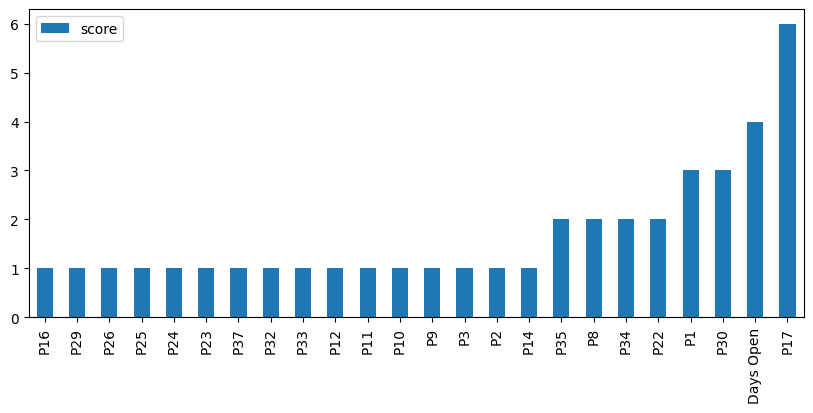

In [32]:
# XGB Feature Importance, relevant features can be selected based on its score
feature_important = xgb_model.get_booster().get_fscore()
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by = 'score', ascending=True)
data.plot(kind='bar', figsize = (10,4))
plt.show()